# Recall Score (Sensibilidad)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import pandas as pd

# Configuración global
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== ANÁLISIS DE PRECISIÓN Y RECALL EN DETECCIÓN DE FRAUDE ===\n")


=== ANÁLISIS DE PRECISIÓN Y RECALL EN DETECCIÓN DE FRAUDE ===



In [3]:
# 1. GENERAR DATASET SIMULANDO DETECCIÓN DE FRAUDE
print("=== CREANDO DATASET ALTAMENTE DESBALANCEADO ===")

X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_clusters_per_class=1,
    weights=[0.995, 0.005],  # 0.5% positivos (fraudes)
    flip_y=0.01,
    random_state=42
)

print(f"Distribución de clases:")
print(f"Clase 0 (Normal): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
print(f"Clase 1 (Fraude): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")


=== CREANDO DATASET ALTAMENTE DESBALANCEADO ===
Distribución de clases:
Clase 0 (Normal): 9911 (99.1%)
Clase 1 (Fraude): 89 (0.9%)


In [5]:
# 2. DIVISIÓN TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamaño entrenamiento: {len(X_train)}")
print(f"Tamaño prueba: {len(X_test)}")


Tamaño entrenamiento: 8000
Tamaño prueba: 2000


In [7]:
# 3. ENTRENAR DIFERENTES MODELOS
print("\n=== ENTRENAMIENTO DE MODELOS ===")

modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    resultados[nombre] = {
        'recall': recall,
        'precision': precision,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'modelo': modelo
    }
    
    print(f"\n=== {nombre} ===")
    print(f"Recall: {recall:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.3f}")



=== ENTRENAMIENTO DE MODELOS ===

=== Random Forest ===
Recall: 0.167
Precision: 1.000
F1-Score: 0.286

=== Logistic Regression ===
Recall: 0.389
Precision: 1.000
F1-Score: 0.560


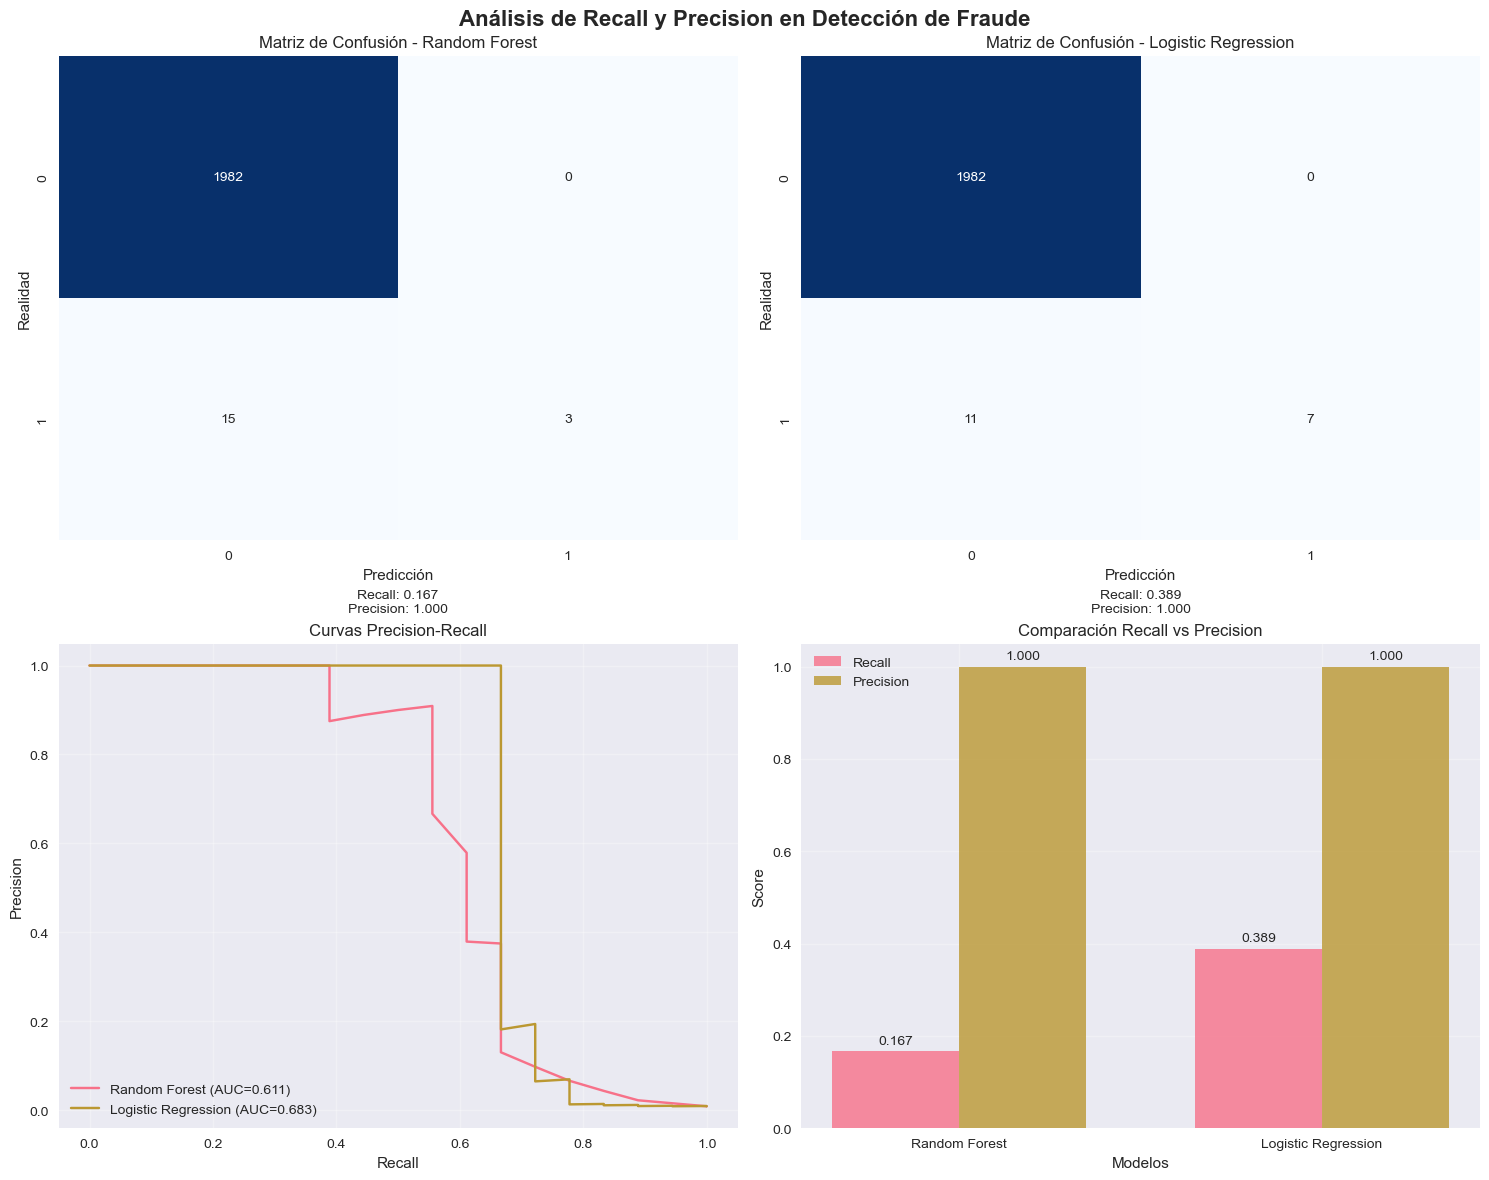

In [9]:
# 4. VISUALIZACIONES PRINCIPALES
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Recall y Precision en Detección de Fraude', fontsize=16, fontweight='bold')

# (1) Matrices de confusión
for i, (nombre, resultado) in enumerate(resultados.items()):
    cm = confusion_matrix(y_test, resultado['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, i], cbar=False)
    axes[0, i].set_title(f'Matriz de Confusión - {nombre}')
    axes[0, i].set_xlabel('Predicción')
    axes[0, i].set_ylabel('Realidad')
    
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    axes[0, i].text(0.5, -0.1, f'Recall: {recall:.3f}\nPrecision: {precision:.3f}', 
                    transform=axes[0, i].transAxes, ha='center', va='top')

# (2) Curvas Precision-Recall
for nombre, resultado in resultados.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, resultado['y_proba'])
    auc_score = auc(recall_curve, precision_curve)
    axes[1, 0].plot(recall_curve, precision_curve, label=f'{nombre} (AUC={auc_score:.3f})')

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Curvas Precision-Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (3) Comparación de métricas
nombres = list(resultados.keys())
recalls = [resultados[n]['recall'] for n in nombres]
precisions = [resultados[n]['precision'] for n in nombres]

x = np.arange(len(nombres))
width = 0.35
axes[1, 1].bar(x - width/2, recalls, width, label='Recall', alpha=0.8)
axes[1, 1].bar(x + width/2, precisions, width, label='Precision', alpha=0.8)
axes[1, 1].set_xlabel('Modelos')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Comparación Recall vs Precision')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(nombres)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

for i, (r, p) in enumerate(zip(recalls, precisions)):
    axes[1, 1].text(i - width/2, r + 0.01, f'{r:.3f}', ha='center', va='bottom')
    axes[1, 1].text(i + width/2, p + 0.01, f'{p:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [11]:
# 5. ANÁLISIS DETALLADO DEL MEJOR MODELO
mejor_modelo = max(resultados.items(), key=lambda x: x[1]['recall'])
nombre_mejor, datos_mejor = mejor_modelo

print(f"\n=== ANÁLISIS DETALLADO: {nombre_mejor} ===")
print(classification_report(y_test, datos_mejor['y_pred'], target_names=['Normal', 'Fraude']))



=== ANÁLISIS DETALLADO: Logistic Regression ===
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      1982
      Fraude       1.00      0.39      0.56        18

    accuracy                           0.99      2000
   macro avg       1.00      0.69      0.78      2000
weighted avg       0.99      0.99      0.99      2000



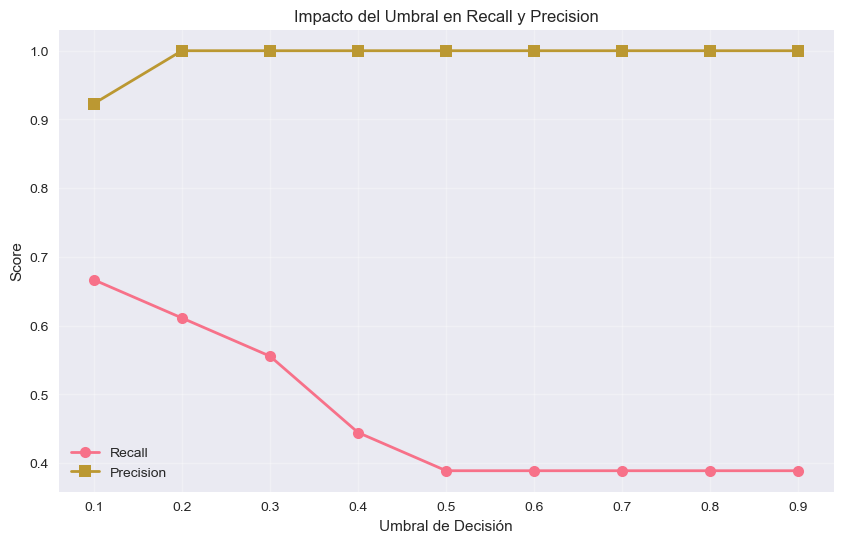

In [13]:
# 6. ANÁLISIS DE UMBRAL DE DECISIÓN
umbrales = np.arange(0.1, 1.0, 0.1)
recall_por_umbral, precision_por_umbral = [], []

for umbral in umbrales:
    y_pred_umbral = (datos_mejor['y_proba'] >= umbral).astype(int)
    
    if sum(y_pred_umbral) > 0:
        recall_umbral = recall_score(y_test, y_pred_umbral)
        precision_umbral = precision_score(y_test, y_pred_umbral)
    else:
        recall_umbral, precision_umbral = 0, 0
    
    recall_por_umbral.append(recall_umbral)
    precision_por_umbral.append(precision_umbral)

plt.figure(figsize=(10, 6))
plt.plot(umbrales, recall_por_umbral, 'o-', label='Recall', linewidth=2, markersize=8)
plt.plot(umbrales, precision_por_umbral, 's-', label='Precision', linewidth=2, markersize=8)
plt.xlabel('Umbral de Decisión')
plt.ylabel('Score')
plt.title('Impacto del Umbral en Recall y Precision')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [17]:
# 7. INTERPRETACIÓN FINAL
print("\n=== CONCLUSIONES ===")
print("1️ Con umbral bajo: Recall alto (detecta más fraudes) pero baja precisión (muchos falsos positivos).")
print("2️ Con umbral alto: Mejora precisión (menos falsas alarmas) pero se pierden fraudes (bajo recall).")
print("3️ El equilibrio depende del costo de cada tipo de error:")
print("   - Falso positivo: molestar a cliente legítimo.")
print("   - Falso negativo: permitir fraude real.")
print("\n En aplicaciones reales, se ajusta el umbral según el costo de negocio y el impacto reputacional.")



=== CONCLUSIONES ===
1️ Con umbral bajo: Recall alto (detecta más fraudes) pero baja precisión (muchos falsos positivos).
2️ Con umbral alto: Mejora precisión (menos falsas alarmas) pero se pierden fraudes (bajo recall).
3️ El equilibrio depende del costo de cada tipo de error:
   - Falso positivo: molestar a cliente legítimo.
   - Falso negativo: permitir fraude real.

 En aplicaciones reales, se ajusta el umbral según el costo de negocio y el impacto reputacional.
